Episode: 1, Step: 0, Reward: 0.0
Episode: 1, Step: 1, Reward: 0.0
Episode: 1, Step: 2, Reward: 0.0
Episode: 1, Step: 3, Reward: 0.0
Episode: 1, Step: 4, Reward: 0.0
Episode: 2, Step: 0, Reward: 0.0
Episode: 2, Step: 1, Reward: 0.0
Episode: 2, Step: 2, Reward: 0.0
Episode: 2, Step: 3, Reward: 0.0
Episode: 2, Step: 4, Reward: 0.0
Temporary case base saved successfully.
Case base saved successfully.


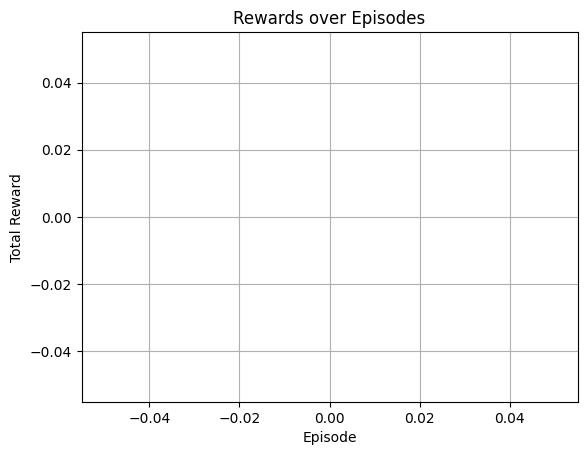

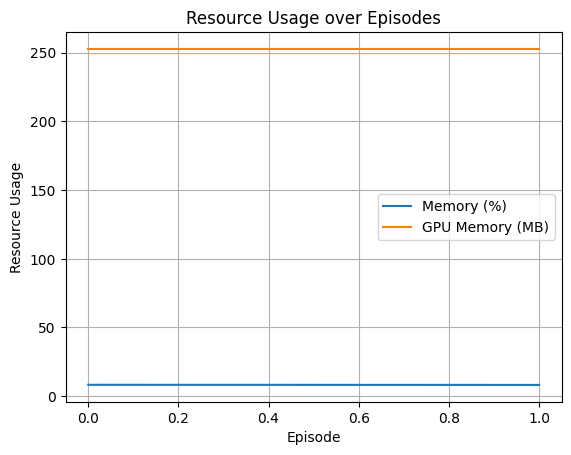

Percentage of Successful Episodes: 0.0%


In [9]:
import numpy as np
import json
import gym
import matplotlib.pyplot as plt
import psutil
import pynvml
from collections import Counter
from gym.envs.registration import register


class CustomRewardFrozenLakeWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        # Execute the action in the original environment
        state, reward, done, info = self.env.step(action)
        
        # Custom reward calculation
        if done:  # If the episode ends
            if state == self.env.goal:  # If the agent reaches the goal
                reward = 100  # Assign a custom reward for reaching the goal
            elif self.env.desc.flatten()[state] == b'H':  # If the agent falls into a hole
                reward = -10  # Assign a custom reward for falling into a hole
            else:
                reward = -1  # Assign a custom negative reward for other states
        
        return state, reward, done, info

# Register the wrapper with a new environment ID
register(
    id='CustomRewardFrozenLake-v1',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.78,  # Adjust the reward threshold if needed
)


class ProblemSolver:
    def __init__(self, actions, epsilon=0.8, gamma=0.99, alpha=0.1):
        self.actions = actions
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.Q = {}  # Q-values table
        self.state_space = None  # Store the state space to initialize Q-values later

    def initialize_Q(self, state_space, actions):
        self.state_space = state_space
        self.actions = actions
        self.Q = {}
        for state in self.state_space:
            self.Q[state] = np.zeros(self.actions)

    def choose_action(self, state):
        if np.isscalar(state):  # Check if state is a scalar (integer or float)
            state_array = np.array([state])  # Convert scalar to numpy array
        else:
            state_array = np.asarray(state)  # Ensure state is a numpy array

        state_tuple = (state_array.item(),) if state_array.ndim == 0 else tuple(state_array.tolist())

        if np.random.rand() < self.epsilon:
            # print("Choosing random action...")
            return np.random.choice(self.actions)
        else:
            if state_tuple in self.Q:  # Use the tuple as the key
                # print("Choosing greedy action...")
                return np.argmax(self.Q[state_tuple])
            else:
                # print("Choosing random action (state not in Q)...")
                return np.random.choice(self.actions)

    def update_Q(self, state, action, reward, next_state, next_action):
        state_tuple = (state,) if np.isscalar(state) else tuple(state)
        next_state_tuple = (next_state,) if np.isscalar(next_state) else tuple(next_state)

        # print(f"Updating Q-value for state {state_tuple} and action {action}")

        if state_tuple not in self.Q:
            self.Q[state_tuple] = np.zeros(self.actions)

        td_target = reward + self.gamma * self.Q[next_state_tuple][next_action]
        td_error = td_target - self.Q[state_tuple][action]

        # print(f"TD Target: {td_target}, TD Error: {td_error}")

        self.Q[state_tuple][action] += self.alpha * td_error
        # print(f"Updated Q-value: {self.Q[state_tuple][action]}")




class QCBRL:
    # In the QCBRL class initialization:
    def __init__(self, actions, threshold=0.2, epsilon=0.2, gamma=0.99, alpha=0.1):
        self.actions = actions
        self.problem_solver = ProblemSolver(actions, epsilon, gamma, alpha)
        self.case_base = []
        self.threshold = threshold
        self.temporary_case_base = []

    
    def initialize_problem_solver(self, state_space):
        self.problem_solver.initialize_Q(state_space, self.actions)


    def train(self, env, episodes, max_steps, render=False):
        env = env
        rewards = []
        episode_rewards = []
        memory_usage = []
        gpu_memory_usage = []
        successful_episodes = 0

        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)

        for episode in range(1, episodes + 1):
            state = env.reset()
            total_reward = 0
            self.temporary_case_base = []
            episode_ended_successfully = False
            
            for step in range(max_steps):
                if render:
                    env.render()
                action = self.take_action(state)
                next_state, reward, done, _ = env.step(action)
                print(f"Episode: {episode}, Step: {step}, Reward: {reward}")  # Add this line to print reward

                self.problem_solver.update_Q(state, action, reward, next_state, self.problem_solver.choose_action(next_state))
            
                state = next_state

                if done:
                    rewards.append(total_reward)
                    episode_rewards.append(total_reward)
                    episode_ended_successfully = reward > 0  # Consider episode successful if reward > 0
                    if episode_ended_successfully:
                        successful_episodes += 1
                    break

            # Case.revise(self.case_base, self.temporary_case_base, episode_ended_successfully)
            # self.case_base = Case.retain(self.case_base, self.temporary_case_base, episode_ended_successfully, self.threshold)

            memory_usage.append(psutil.virtual_memory().percent)
            gpu_memory_usage.append(pynvml.nvmlDeviceGetMemoryInfo(handle).used / 1024**2)

        self.save_case_base_temporary()
        self.save_case_base()

        env.close()
        self.plot_rewards(episode_rewards)
        self.plot_resources(memory_usage, gpu_memory_usage)

        success_percentage = (successful_episodes / episodes) * 100
        print(f"Percentage of Successful Episodes: {success_percentage}%")

    def take_action(self, state):
        if np.isscalar(state):
            state_array = np.array([state])
        else:
            state_array = np.asarray(state)

        action = self.problem_solver.choose_action(state_array)

        return action

    def save_case_base_temporary(self):
        filename = "case_base_temporary.json"
        case_base_data = [{"problem": case.problem.tolist() if isinstance(case.problem, np.ndarray) else int(case.problem), 
                        "solution": int(case.solution), 
                        "trust_value": int(case.trust_value)} for case in self.temporary_case_base]
        with open(filename, 'w') as file:
            json.dump(case_base_data, file)
        print("Temporary case base saved successfully.")

    def save_case_base(self):
        filename = "case_base.json"
        case_base_data = [{"problem": case.problem.tolist(), "solution": case.solution, "trust_value": case.trust_value} for case in self.case_base]
        with open(filename, 'w') as file:
            json.dump(case_base_data, file)

            print("Case base saved successfully.")
        
    def load_case_base(self):
        filename = "case_base.json"
        try:
            with open(filename, 'r') as file:
                case_base_data = json.load(file)
                self.case_base = [Case(np.array(case["problem"]), case["solution"], case["trust_value"]) for case in case_base_data]
                print("Case base loaded successfully.")
        except FileNotFoundError:
            print("Case base file not found. Starting with an empty case base.")

    def plot_rewards(self, rewards):
        plt.plot(rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Rewards over Episodes')
        plt.grid(True)
        plt.show() 

    def plot_resources(self, memory_usage, gpu_memory_usage):
        plt.plot(memory_usage, label='Memory (%)')
        plt.plot(gpu_memory_usage, label='GPU Memory (MB)')
        plt.xlabel('Episode')
        plt.ylabel('Resource Usage')
        plt.title('Resource Usage over Episodes')
        plt.legend()
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    env = gym.make('CustomRewardFrozenLake-v1')
     # Create an instance of the environment
    actions = env.action_space.n  # Number of actions in FrozenLake-v1
    agent = QCBRL(actions, env)
    state_space = [(s,) for s in range(env.observation_space.n)]  # Assuming discrete state space
    agent.initialize_problem_solver(state_space)
    agent.train(env, episodes=2, max_steps=5)
